In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Ask Salesforce in BigQuery

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/cortex-applayer/blob/main/apps/Ask_Cortex/ask_sfdc_in_bq.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fcortex-applayer%2Fmain%2Fapps%2FAsk_Cortex%2Fask_sfdc_in_bq.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/cortex-applayer/blob/main/apps/Ask_Cortex/ask_sfdc_in_bq.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/cortex-applayer/blob/main/apps/Ask_Cortex/ask_sfdc_in_bq.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
|Author(s) | [Vlad Kolesnikov](https://github.com/vladkol) |

## Overview

In this tutorial, you will learn how to use Gemini's [Long Context Learning](https://ai.google.dev/gemini-api/docs/long-context)
for converting natural language questions to SQL queries for
[Salesforce Sales Cloud](https://www.salesforce.com/sales/cloud/) data in [Google Cloud BigQuery](https://cloud.google.com/bigquery).

Having 2M token context allow Gemini 1.5 Pro to learn from an entire database schema and its metadata. The schema is generated using a real Salesforce.com instance and its data replicated to a BigQuery dataset.

To run this tutorial, you need a Gemini API key and access to BigQuery:

* Get a Gemini API key [here](https://aistudio.google.com/app/apikey).
* For BigQuery, use **Project ID** of your [Google Cloud project](https://console.cloud.google.com/iam-admin/settings) or [BigQuery Sandbox](https://cloud.google.com/bigquery/docs/sandbox).


## Configuration

### Gemini API Key and Model Name

Get a Gemini API key [here](https://aistudio.google.com/app/apikey).

In [2]:
# { display-mode: "form" }
GEMINI_API_KEY = "" # @param {type:"string"}
GEMINI_MODEL = "gemini-1.5-pro-001" # This notebook is optimized for Gemini 1.5 Pro
GEMINI_UTIL_MODEL = "gemini-1.5-flash-001"

### BigQuery Project

Use **Project ID** of your [Google Cloud project](https://console.cloud.google.com/iam-admin/settings) or [BigQuery Sandbox](https://cloud.google.com/bigquery/docs/sandbox).

In [3]:
# { display-mode: "form" }

BIGQUERY_PROJECT_ID = ""  # @param {type:"string"}

### Install Dependencies

In [4]:
%pip install -U google-cloud-bigquery[pandas] google-generativeai altair 1>/dev/null && echo "Python dependencies have been installed."

try:
  import requests
except ModuleNotFoundError:
  %pip install -U requests

Python dependencies have been installed.


## Initialize Models

### Model Configuration

In [5]:
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold

if not GEMINI_API_KEY:
    print("GEMINI_API_KEY should not be empty. Gen an API key here: https://aistudio.google.com/app/apikey")
    assert False

genai.configure(api_key=GEMINI_API_KEY)

generation_config = {
    "temperature": 0,
    "top_p": 0.95,
    "top_k": 4,
    "max_output_tokens": 8192,
    "response_mime_type": "text/plain",
}
safety_settings = {
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH
}

### System Instructions

System Instructions establish the model's role, SQL generation rules, and full dataset schema including Salesforce.com metadata for repective tables and columns.

The dataset schema enhanced with the metadata contains decriptions of every table and column, dimension values, relationships, and other details.

Here is a part of the schema for `opportunities` table:

```json
{
"opportunities": {
    "table_name": "opportunities",
    "table_description": "Opportunities",
    "source_salesforce_object": "Opportunity",
    "columns": {
      "Id": {
        "name": "Id",
        "type": "STRING",
        "description": "[IN SALESFORCE]: Id of Opportunity\nCannot be NULL\n"
      },
      "AccountId": {
        "name": "AccountId",
        "type": "STRING",
        "mode": "NULLABLE",
        "description": "[IN SALESFORCE]: Account ID\nCan be NULL\n\nRefers to table(s) with following Salesforce object(s): Account"
      },
      "RecordTypeId": {
        "name": "RecordTypeId",
        "type": "STRING",
        "mode": "NULLABLE",
        "description": "[IN SALESFORCE]: Record Type ID\nCan be NULL\n\nRefers to table(s) with following Salesforce object(s): RecordType"
      },
      "Name": {
        "name": "Name",
        "type": "STRING",
        "description": "[IN SALESFORCE]: Name of Opportunity\nCannot be NULL\n"
      },
      "Description": {
        "name": "Description",
        "type": "STRING",
        "mode": "NULLABLE",
        "description": "[IN SALESFORCE]: Description of Opportunity\nCan be NULL\n"
      },
      "StageName": {
        "name": "StageName",
        "type": "STRING",
        "mode": "NULLABLE",
        "description": "[IN SALESFORCE]: Stage\nCannot be NULL\n\nPossible values: \n* `Prospecting` (Prospecting)\n* `Qualification` (Qualification)\n* `Needs Analysis` (Needs Analysis)\n* `Value Proposition` (Value Proposition)\n* `Id. Decision Makers` (Id. Decision Makers)\n* `Perception Analysis` (Perception Analysis)\n* `Proposal/Price Quote` (Proposal/Price Quote)\n* `Negotiation/Review` (Negotiation/Review)\n* `Closed Won` (Closed Won)\n* `Closed Lost` (Closed Lost)\n* `Actual Target` (Actual Target)\n\n"
      }
   }
}
```

In [6]:
from pathlib import Path
import requests
from IPython.display import display, Code, Markdown

sfdc_metadata_local = Path("sfdc_metadata.json")
if sfdc_metadata_local.exists():
  sfdc_cortex_schema = sfdc_metadata_local.read_text()
else:
  sfdc_cortex_schema = requests.get(
      "https://storage.googleapis.com/cortex-public-documents/gemini/sfdc-bq-schema_07-2024.json").text
  sfdc_metadata_local.write_text(sfdc_cortex_schema)
sfdc_cortex_schema = sfdc_cortex_schema.replace("[IN SALESFORCE]: ", "")

system_instructions = f"""
You are an experienced Data Engineer working with data warehouses in Google Cloud BigQuery.
You write correct, clean and performant BigQuery SQL.
You used to work as Salesforce Sales Cloud consultant and developer.
You have an MBA degree, and experience running a business.

You will be asked different questions. If a question can be answered using CRM data in Salesforce Sales Cloud, use the following approach.

First, generate a step-by-step algorithm for answering the question. It's an important stage.
ALGORITHM RULES:
        - If mentioning any metrics, scores or criteria, DEFINE THEM YOURSELF, including formulas or rules to calculate.
        - If any thresholds or value intervals are mentioned, DEFINE them YOURSELF with specific values.
        - When defining something, be very specific.
        - The algorithm will be later used to generate SQL queries and dashboards.
        - Do not include specific field names to your answer.
        - Do not generate code or SQL.
        - Do not tell what fields to select or by what field to filter.
        - Follow instructions in the question.
        - DO NOT REFER TO SPECIFIC TABLES OR FIELDS.

Evaluate whether the algorithm can be executed using Salesforce Sales Cloud data. Adjust it as necessary. Show the final algorithm.

Next step is to convert the algorithm to BigQuery SQL query.
You Salesforce Sales Cloud data is available as tables in a BigQuery dataset.
Generate a BigQuery SQL query that implements the algorithm.
Use ONLY tables and fields from the table specifications below (goes after `[TABLES_FIELDS]`).
Your BigQuery project is `kittycorn-public`.
Your BigQuery dataset is `sfdc__raw__6_0__us`.

SQL Generation rules:

- Table and field names are case-sensitive.
- Exclude tables and fields that are not relevant to the algorithm (except names or descriptions).
- Pay special attention to date dimensions.
- When using constants in WHERE statements with fields that have "Possible Values" in the description, perform comparison against all relevant values using `IN` rather than `=` (equal).
- Do not impose filters (WHERE statements) or JOIN predicates that are not required.
- For Geographical dimensions, if you need to filter on them (AND ONLY IF YOU NEED!):
  - For countries ALWAYS check using multiple forms, including ISO code.
      Example: for `United States`, instead of writing `Country='US'`, write `Country IN ('US', 'USA', 'United States')`.
  - For states and provinces ALWAYS check using multiple forms people may use it in.
      Example: Instead of writing `State='Florida'`, write `State IN ('FL', 'Florida')`.
      Example: Instead of writing `State='TX'`, write `State IN ('TX', 'Texas')`.
  - When multiple states are supposed to be checked, use all forms of all states.
      Example: Instead of writing `State IN ('TX', 'FL')`, write `State IN ('TX', 'Texas', 'FL', 'Florida')`.
  - Do not make geographical names up.
  - Only filter by fields that are necessary for implementing the algorithm.
- Make the query as simple as possible, but implementing the algorithm.
- Pay attention to what kind of join you use.
- IMPORTANT: Make sure you include IDs and Names of entities required by the algorithm.
- Unique Id field may have name `Id` or `{{Entity}}Id`  where `{{Entity}}` is a singular name of entity type this table stores.
    For example, a table that stores Opportunities may have unique Id field with name `OpportunityId`.
- Each used table must have a random alias. Each field must be specified with a table alias.
- All table references should be fully-qualified with project and dataset.
- Any constants you need - make sure they exist in BigQuery or defined in the query you generate.

The results will be visualized in a dashboard for a human.
You have Salesforce data in BigQuery.
Do not put restrictions, filters or limits that are not defined in the algorithm or the original question.

If you need metrics and/or dimensions and/or calculations that
cannot be done with the data in tables above, adjust the algorithm to have them excluded,
but try to come up with alternative steps in the SQL. NO PLACEHOLDERS, only executable SQL code.

Your output must be a valid BigQuery SQL query. Do not use anything that will not run in BigQuery's GoogleSQL.

Once you generated SQL code, evaluate the query on following all SQL Generation rules.
Pay special attention to using proper columns with proper tables.

If you cannot answer the question with Salesforce data in BigQuery or if running SQL is not enough to implement the algorithm, let the user know what's missing.

Otherwise, finish your answer with a final correct BigQuery SQL.

[TABLES_FIELDS]
{sfdc_cortex_schema}
"""

### Initialize Models and a Chat

This tutorial's prompts are optimized Gemini 1.5 Pro (`gemini-1.5-pro-001`).

In [7]:
model = genai.GenerativeModel(
    model_name=GEMINI_MODEL,
    generation_config=generation_config,
    safety_settings=safety_settings,
    system_instruction=system_instructions)
chat_session = model.start_chat()

# Additional model to perform utility operations.
model_util = genai.GenerativeModel(
    model_name=GEMINI_UTIL_MODEL,
    generation_config=generation_config,
    safety_settings=safety_settings,
    system_instruction="""
     - You are an experienced Data Engineer working with data warehouses in Google Cloud BigQuery.
     - You write correct, clean and performant BigQuery SQL.
     - You carefully follow instructions on output format.
     """)

## Generate Entity Relationship Diagram

First, let's ask Gemini to generate an Entity Relationship Diagram straight from the dataset schema.

In [8]:
erd_code = model.generate_content(f"""Generate our database ERD in Mermaid format in Markdown.
                                  Choose the best layout given the schema and the diagram content.
                                  Preserve correct names.

                                  [TABLES_FIELDS]
                                  {sfdc_cortex_schema}
                                  """).text
erd_code = erd_code.split("```mermaid", 1)[-1].rsplit("```", 1)[0].strip()

### Vizualize the diagram

In [20]:
import sys

if "google.colab" in sys.modules:
  from IPython.display import HTML

  mermaid_html = f"""
  <!DOCTYPE html>
  <html lang="en">
    <head>
    <script src="https://cdn.jsdelivr.net/npm/mermaid/dist/mermaid.min.js"></script>
    </head>
  <body>
  <pre>
    <code class="language-mermaid">
    {erd_code}
    </code>
  </pre>
  </body>
  <script>
  var config = {{
      startOnLoad:true,
      theme: 'forest',
      er:{{
              useMaxWidth:true,
              htmlLabels:true,
              entityPadding:12
          }}
  }};
  mermaid.initialize(config);
  window.mermaid.init(undefined, document.querySelectorAll('.language-mermaid'));
  </script>
  </html>
  """
  display(HTML(mermaid_html))
else:
  display(Markdown(f"```mermaid\n{erd_code}\n```"))

[![](https://mermaid.ink/svg/pako:eNqNlM9uhCAQxl_FcN59AW_9c2lS06Q99OJlAqOSKrOBoc3G3XcvlmZ1o6LcgB8z3zfA9EKSQpELtM8aagtdabIwQEryhl12uRyP1I_zPCtFAY7RvqMkq15UKZaPSHAY-Ye4k0DJMEjeSeM3mr0snU5k2RvNeq8YBve1E_UO7Qp6szSrxlPcWUcn_j4bWufm3jZDj96SkUdfs4gtgtpUeget5LxXv8DCJGsUtPQW334M2hVwrHmSmj6-FDhxm8Ki-S1qfnkpeqxLippcm0VgVI_nTfI1_OWClK70LrwAA3UUIA6iQ9uBVqF99MOpUnCDHZZiIBVW4Fse4l0DCp7p42ykyNl6PAhLvm5EXkHrwsyfVND734Fuq6g0ky1ig_rrU9dfVvmOug?type=png)](https://mermaid.live/edit#pako:eNqNlM9uhCAQxl_FcN59AW_9c2lS06Q99OJlAqOSKrOBoc3G3XcvlmZ1o6LcgB8z3zfA9EKSQpELtM8aagtdabIwQEryhl12uRyP1I_zPCtFAY7RvqMkq15UKZaPSHAY-Ye4k0DJMEjeSeM3mr0snU5k2RvNeq8YBve1E_UO7Qp6szSrxlPcWUcn_j4bWufm3jZDj96SkUdfs4gtgtpUeget5LxXv8DCJGsUtPQW334M2hVwrHmSmj6-FDhxm8Ki-S1qfnkpeqxLippcm0VgVI_nTfI1_OWClK70LrwAA3UUIA6iQ9uBVqF99MOpUnCDHZZiIBVW4Fse4l0DCp7p42ykyNl6PAhLvm5EXkHrwsyfVND734Fuq6g0ky1ig_rrU9dfVvmOug)

## Question

Now, let's go through the flow of generating BigQuery SQL code that answer a natural language query.

In [10]:
# { display-mode: "form" }
QUESTION = "Top 5 customers in every country." # @param {type:"string"}

### Rephrase the Question

In [11]:
rephrased_question = model.generate_content(f"""
    Rephrase the following question using the following rules:
    1. If you need to define a KPI, criteria, etc., try to do it yourself - don't leave placeholders.
    2. When rephrasing, keep in mind that to get the answer, your the question will be converted to BigQuery SQL.
    3. Your output is the rephrased question only in plain text.
    Question:
    ```
    {QUESTION}
    ```
""").text
display(Markdown(f"## Rephrased Question\n\n{rephrased_question}"))

## Rephrased Question

What are the names and IDs of the 5 Accounts with the highest number of associated Opportunities in each Billing Country? 


## Generate SQL

In [12]:
result_text = chat_session.send_message(rephrased_question).text
display(Markdown(f"### SQL\n\n{result_text}"))

### SQL

```sql
WITH AccountOpportunityCount AS (
    SELECT
        a.BillingCountry,
        a.Id AS AccountId,
        a.Name AS AccountName,
        COUNT(o.Id) AS OpportunityCount
    FROM
        `kittycorn-public.sfdc__raw__5_3__us.accounts` AS a
    LEFT JOIN
        `kittycorn-public.sfdc__raw__5_3__us.opportunities` AS o ON a.Id = o.AccountId
    GROUP BY
        a.BillingCountry, a.Id, a.Name
),
RankedAccountOpportunityCount AS (
    SELECT
        BillingCountry,
        AccountId,
        AccountName,
        OpportunityCount,
        ROW_NUMBER() OVER (PARTITION BY BillingCountry ORDER BY OpportunityCount DESC) AS Rank
    FROM
        AccountOpportunityCount
)
SELECT
    BillingCountry,
    AccountId,
    AccountName,
    OpportunityCount
FROM
    RankedAccountOpportunityCount
WHERE
    Rank <= 5
ORDER BY
    BillingCountry,
    OpportunityCount DESC;
```


### Extract SQL Code

In [13]:
def extract_sql(markdown: str) -> str:
    if "```sql" in markdown:
        query = markdown.split("```sql", 1)[-1].rsplit("```", 1)[0].strip()
    elif "```googlesql" in markdown:
        query = markdown.split("```googlesql", 1)[-1].rsplit("```", 1)[0].strip()
    elif "```bigquery" in markdown:
        query = markdown.split("```bigquery", 1)[-1].rsplit("```", 1)[0].strip()
    else:
        query = markdown
    return query

query = extract_sql(result_text)

### Initialize BigQuery client

In [14]:
import sys
from google.cloud import bigquery

if not BIGQUERY_PROJECT_ID:
    print("BIGQUERY_PROJECT should not be empty. Please specify a Google Cloud Project Id.")
    assert False

if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user(project_id=BIGQUERY_PROJECT_ID)

bq_client = bigquery.Client(project=BIGQUERY_PROJECT_ID, location="US")

### Validate and correct SQL

Now, we validate generated SQL code by performing a [query dry run](https://cloud.google.com/bigquery/docs/samples/bigquery-query-dry-run) in BigQuery.
Dry run allows us to validate the query and find errors without fully running it over our data.

If any error occurs during a dry run, we ask Gemini to correct the error by making respective changes in SQL code.

In [15]:
from google.cloud.exceptions import BadRequest, NotFound

MAX_FIX_ATTEMPTS = 32
validating_query = query
is_good = False

job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
corr_results = []

for __ in range(MAX_FIX_ATTEMPTS):
    try:
      _ = bq_client.query(validating_query, job_config=job_config).result()
      is_good = True
      query = validating_query
      break
    except (BadRequest, NotFound) as ex:
      err_text = ex.args[0].strip()
      display(Markdown(f"\n\n**Invalid SQL query. Trying to fix it.**\n\nError: {err_text}\n\n"))

      correcting_prompt = f"""```sql
        {validating_query}
        ```

      ERROR: {err_text}
      """
      corr_result = chat_session.send_message(correcting_prompt).text.strip()
      if corr_result in corr_results:
         not_again_prompt = """
          You already suggested this change. It didn't work.
          Try something else. Use the schema."""
         corr_result = chat_session.send_message(not_again_prompt).text.strip()
      else:
         validating_query = extract_sql(corr_result)
      corr_results.append(corr_result)

if not is_good:
  display(Markdown(f"Couldn't generate a valid BigQuery SQL query."))
  display(Code(validating_query, language="sql"))
  assert False
else:
   display(Code(query, language="sql"))

WITH AccountOpportunityCount AS (
    SELECT
        a.BillingCountry,
        a.Id AS AccountId,
        a.Name AS AccountName,
        COUNT(o.Id) AS OpportunityCount
    FROM
        `kittycorn-public.sfdc__raw__5_3__us.accounts` AS a
    LEFT JOIN
        `kittycorn-public.sfdc__raw__5_3__us.opportunities` AS o ON a.Id = o.AccountId
    GROUP BY
        a.BillingCountry, a.Id, a.Name
),
RankedAccountOpportunityCount AS (
    SELECT
        BillingCountry,
        AccountId,
        AccountName,
        OpportunityCount,
        ROW_NUMBER() OVER (PARTITION BY BillingCountry ORDER BY OpportunityCount DESC) AS Rank
    FROM
        AccountOpportunityCount
)
SELECT
    BillingCountry,
    AccountId,
    AccountName,
    OpportunityCount
FROM
    RankedAccountOpportunityCount
WHERE
    Rank <= 5
ORDER BY
    BillingCountry,
    OpportunityCount DESC;

## Execute SQL in BigQuery

In [16]:
results_df = bq_client.query(query).result().to_dataframe()
results_df

,BillingCountry,AccountId,AccountName,OpportunityCount
0,,0018a000022jPn9AAE,Kittycorn LLC,1
1,,0018a0000260eJzAAI,Account for Laptop,1
2,France,0018a00001uyzi2AAA,Pyramid Construction Inc.,2576
3,USA,0018a00001uyzi0AAA,Edge Communications,3424
4,USA,0018a00001uyzhxAAA,GenePoint,3081
5,USA,0018a00001uyzi1AAA,Burlington Textiles Corp of America,2348
6,USA,0018a00001uyzhwAAA,sForce,2326
7,USA,0018a00001uyzhuAAA,University of Arizona,2323


## Build a Chart

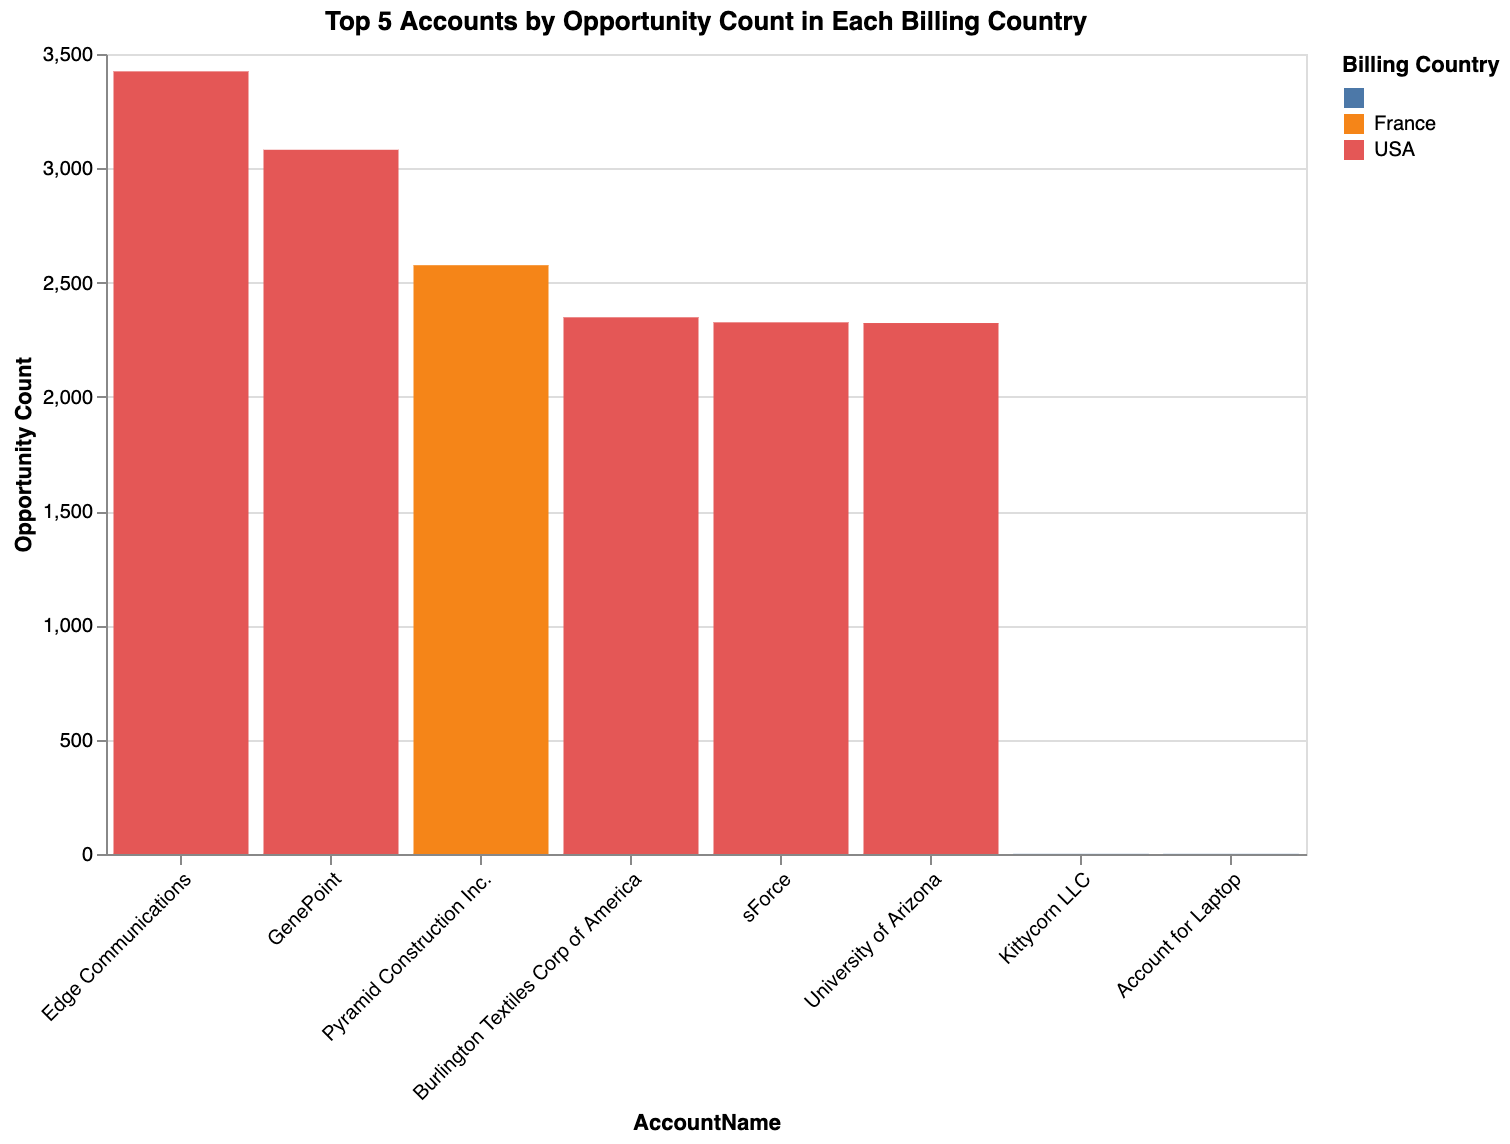

In [2]:
import altair as alt
import json
import jsonschema

chart_prompt = f"""
You have SQL code:
```sql
{query}
```

And you have data (up to first 10 rows, we may have more):
```
{results_df.head(10)}
```

Generate a chart code in Vega Lite 4 format.
* For dimensions, prefer names of entities over their ids.
For example, if there is a CustomerId column and CustomerName column in the data, choose CustomerName as a chart dimension. So, pay attention to "name" columns.

RULES:
* Only one chart is allowed.
* Your data model is BigQuery query you already have.
* Make sure to come up with a good title for the chart.
* Make sure the chart will look good in a dashboard. Apply reasonable filters to make it look good.
* Make sure the legend truly represents the chart. Pay additional attention to units of the legend.
* Use entity names over their identifiers in the chart - it will be seen by a human.
* Visualize values that are the best to answer the prompt.
* Keep it simple, but good looking.

Do not make the chart too small.
DO NOT MAKE UP FUNCTIONS OR PROPERTIES THAN DON'T EXIST IN Vega Lite 4 schema!
Chart must be the best way to answer the question directly or provide data to do so.

Just the remember, the original question was:
```
{QUESTION}
```

The rephrased version of it:
```
{rephrased_question}
```
"""

chart_chat = model.start_chat()
chart_json = chart_chat.send_message(chart_prompt).text

while True:
  if "```vega-lite" in chart_json:
    vega = chart_json.split("```vega-lite", 1)[-1].rsplit("```", 1)[0]
  elif "```vega" in chart_json:
    vega = chart_json.split("```vega", 1)[-1].rsplit("```", 1)[0]
  elif "```json" in chart_json:
    vega = chart_json.split("```json", 1)[-1].rsplit("```", 1)[0]
  else:
    vega = chart_json
  vega_dict = json.loads(vega)
  vega_dict["data"] = {
      "values": []
  }
  try:
    vega_chart = alt.Chart.from_dict(vega_dict)
    break
  except jsonschema.ValidationError as ex:
    display(Markdown(f"\n\n**Invalid Vega Lite json. Trying to fix it.**\n\nError: {ex.message}"))
    chart_json = chart_chat.send_message(ex.message).text

rows_dicts = results_df.to_dict("records")
vega_dict["data"] = {
      "values": rows_dicts
  }
vega_chart = alt.Chart.from_dict(vega_dict)
vega_chart.display()